In [10]:
import sys
import os
sys.path.append(os.path.abspath("../src"))
sys.path.append(os.path.abspath("../"))

In [11]:
import os
import numpy as np
from pathlib import Path
from tqdm import tqdm
from scipy import ndimage
from scipy.ndimage import uniform_filter, minimum_filter, maximum_filter
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score, precision_score, recall_score,confusion_matrix, 
                             f1_score, roc_auc_score, classification_report)
import joblib
import gc
from utils import load_and_normalize_tiff, load_mask
import json
from visualization import plot_image_and_mask

import warnings
from rasterio.errors import NotGeoreferencedWarning
warnings.filterwarnings("ignore", category=NotGeoreferencedWarning)

In [12]:
class Config:
    PROCESSED_DATA = Path("../data/processed")
    OUTPUT_PATH = Path("../outputs")
    MODEL_PATH = OUTPUT_PATH / "models"
    os.makedirs(MODEL_PATH, exist_ok=True)
    
    BATCH_SIZE = 262144  # Pixels per batch
    N_EPOCHS = 20
    VAL_SPLIT = 0.2
    TEST_SPLIT = 0.1
    
    EARLY_STOP_PATIENCE = 10
    EARLY_STOP_DELTA = 0.001
    
    SGD_PARAMS = {
        'loss': 'log_loss',
        'penalty': 'elasticnet',
        'alpha': 0.0005,
        'l1_ratio': 0.15,
        'learning_rate': 'adaptive',
        'eta0': 0.02,
        'max_iter': 1,
        'class_weight': 'balanced',
        'n_jobs': os.cpu_count()
    }
    
    SPATIAL_WINDOW_SIZES = [3, 5]
    
    SPATIAL_WINDOW = 3  # 3x3 window for spatial features
    TEXTURE_WINDOW = 5  # 5x5 window for texture features

config = Config()

In [13]:
def calculate_texture_features(band, window_size):
    features = []
    
    entropy = uniform_filter(band * np.log(band + 1e-10), size=window_size)
    features.append(entropy)
    
    mean = uniform_filter(band, size=window_size)
    variance = uniform_filter((band - mean)**2, size=window_size)
    features.append(variance)

    min_val = minimum_filter(band, size=window_size)
    max_val = maximum_filter(band, size=window_size)
    range_val = max_val - min_val + 1e-6
    homogeneity = 1.0 / range_val
    features.append(homogeneity)
    
    return np.stack(features, axis=-1)

def calculate_spectral_indices(image):
    bands = []
    for i in range(image.shape[0]):
        band = image[i].astype('float32')
        band = np.nan_to_num(band, nan=0.0)
        bands.append(band)
    
    red, green, blue, nir = bands
    
    indices = {}
    eps = 1e-6
    
    with np.errstate(divide='ignore', invalid='ignore'):
        indices['ndvi'] = np.nan_to_num((nir - red) / (nir + red + eps), nan=0.0)
        indices['ndwi'] = np.nan_to_num((green - nir) / (green + nir + eps), nan=0.0)
        indices['evi'] = np.nan_to_num(2.5 * (nir - red) / (nir + 6 * red - 7.5 * blue + 1 + eps), nan=0.0)
        indices['vari'] = np.nan_to_num((green - red) / (green + red - blue + eps), nan=0.0)
        indices['sr'] = np.nan_to_num(nir / (red + eps), nan=0.0)
        indices['si'] = np.nan_to_num((1 - blue) * (1 - green) * (1 - red), nan=0.0)
        indices['ndbi'] = np.nan_to_num((nir - green) / (nir + green + eps), nan=0.0)
        indices['ndsi'] = np.nan_to_num((nir - blue) / (nir + blue + eps), nan=0.0)
        indices['savi'] = np.nan_to_num((nir - red) / (nir + red + 0.5), nan=0.0)

    for key in indices:
        indices[key] = np.clip(indices[key], -1, 1)
    
    return indices

def calculate_spatial_features(band, window_size):
    mean = uniform_filter(band, size=window_size)
    mean_sq = uniform_filter(band**2, size=window_size)
    variance = np.maximum(mean_sq - mean**2, 0.0)
    std = np.sqrt(variance)
    
    min_val = minimum_filter(band, size=window_size)
    max_val = maximum_filter(band, size=window_size)
    range_val = max_val - min_val
    
    epsilon = 1e-10
    skewness = uniform_filter((band - mean)**3, size=window_size) / (std**3 + epsilon)
    kurtosis = uniform_filter((band - mean)**4, size=window_size) / (std**4 + epsilon) - 3
    local_contrast = max_val - min_val
    
    return np.stack([mean, std, min_val, max_val, range_val, skewness, kurtosis, local_contrast], axis=-1)

def extract_features(image, indices=None):
    if indices is None:
        indices = calculate_spectral_indices(image)
    
    n_bands = image.shape[0]
    n_spectral = len(indices) if indices else 0
    n_spatial_per_band = 8 
    n_texture_per_band = 3 
    n_scales = len(config.SPATIAL_WINDOW_SIZES)
    
    total_features = (
        n_bands +
        n_spectral +
        n_bands * n_spatial_per_band * n_scales +
        n_bands * n_texture_per_band
    )
    
    image = np.transpose(image, (1, 2, 0))
    h, w, c = image.shape
    n_pixels = h * w
    
    features = np.zeros((n_pixels, total_features), dtype='float32')
    
    features[:, 0:c] = image.reshape(n_pixels, c)
    col_idx = c
    
    if indices:
        for idx_name, idx_values in indices.items():
            features[:, col_idx] = idx_values.ravel()
            col_idx += 1
    
    for band_idx in range(c):
        band = image[:, :, band_idx]
        for scale_idx, window_size in enumerate(config.SPATIAL_WINDOW_SIZES):
            spatial = calculate_spatial_features(band, window_size)
            start_col = col_idx + band_idx * n_spatial_per_band * n_scales + scale_idx * n_spatial_per_band
            end_col = start_col + n_spatial_per_band
            features[:, start_col:end_col] = spatial.reshape(n_pixels, n_spatial_per_band)
    
    col_idx = c + n_spectral + c * n_spatial_per_band * n_scales
    
    for band_idx in range(c):
        band = image[:, :, band_idx]
        texture = calculate_texture_features(band, config.TEXTURE_WINDOW)
        start_col = col_idx + band_idx * n_texture_per_band
        end_col = start_col + n_texture_per_band
        features[:, start_col:end_col] = texture.reshape(n_pixels, n_texture_per_band)
    
    features = np.nan_to_num(features, nan=0.0, posinf=0.0, neginf=0.0)
    
    return features

In [14]:
class CloudDataset:
    def __init__(self, image_pairs):
        self.image_pairs = image_pairs
        self.class_weights = None
        
    def _stratified_sampling(self, mask, n_samples):
        flat_mask = mask.ravel()
        cloud_idx = np.where(flat_mask == 1)[0]
        clear_idx = np.where(flat_mask == 0)[0]
        
        n_cloud = int(n_samples * 0.5)
        n_clear = n_samples - n_cloud
        
        sampled_cloud = np.random.choice(cloud_idx, min(n_cloud, len(cloud_idx)), replace=False)
        sampled_clear = np.random.choice(clear_idx, min(n_clear, len(clear_idx)), replace=False)
        
        return np.concatenate([sampled_cloud, sampled_clear])
    
    def batch_generator(self):
        for img_path, mask_path, _ in self.image_pairs:
            image = load_and_normalize_tiff(img_path)
            
            mask = load_mask(mask_path)
            indices = calculate_spectral_indices(image)
            
            features = extract_features(image, indices)
            features = np.nan_to_num(features, nan=0.0)
            labels = mask.ravel()
            
            n_batches = len(labels) // config.BATCH_SIZE
            for i in range(n_batches):
                batch_idx = self._stratified_sampling(mask, config.BATCH_SIZE)
                
                X_batch = features[batch_idx]
                y_batch = labels[batch_idx]
                
                assert not np.isinf(features).any(), "Infinite values detected in features"
                yield X_batch, y_batch
            # memory ahhhhhhhhhhh    
            del image, mask, features
            gc.collect()
    
    def calculate_class_weights(self):
        """Compute global class weights"""
        class_counts = {0: 0, 1: 0}
        for _, mask_path, _ in self.image_pairs:
            mask = load_mask(mask_path)
            unique, counts = np.unique(mask, return_counts=True)
            for cls, cnt in zip(unique, counts):
                class_counts[cls] += cnt
        
        total = sum(class_counts.values())
        self.class_weights = {
            0: total / (2 * class_counts[0]),
            1: total / (2 * class_counts[1])
        }

In [15]:
def calculate_metrics(y_true, y_pred, y_proba=None):
    metrics = {
        'accuracy': accuracy_score(y_true, y_pred),
        'precision': precision_score(y_true, y_pred),
        'recall': recall_score(y_true, y_pred),
        'f1': f1_score(y_true, y_pred),
        'confusion_matrix': confusion_matrix(y_true, y_pred).tolist(),
        'classification_report': classification_report(y_true, y_pred, output_dict=True)
    }
    
    if y_proba is not None:
        metrics['roc_auc'] = roc_auc_score(y_true, y_proba)
    return metrics

def save_metrics(metrics, name, output_dir):
    metrics_path = output_dir/ "logs" / f"{name}_metrics.json"
    with open(metrics_path, 'w') as f:
        json.dump(metrics, f, indent=4)
    print(f"Saved {name} metrics to {metrics_path}")

In [16]:
def predict_full_image(model, image_path, output_path=None):
    image = load_and_normalize_tiff(image_path)
    
    indices = calculate_spectral_indices(image)
    features = extract_features(image, indices)

    proba = model.predict_proba(features)[:, 1]
    mask = proba.reshape(512, 512)

    mask = (mask > 0.5).astype(np.uint8)  
    mask = ndimage.binary_closing(mask)
    
    if output_path:
        plot_image_and_mask(image, mask, output_path)
        print(f"Saved prediction to {output_path}")
    
    return mask

In [ ]:
def train_model(train_gen_func, val_gen_func, class_weights):
    model = SGDClassifier(**{**config.SGD_PARAMS, 'class_weight': class_weights})
    best_f1 = 0
    all_metrics = {'val': [], 'test': {}}
    no_improvement_count = 0

    for epoch in range(config.N_EPOCHS):
        print(f"\nEpoch {epoch + 1}/{config.N_EPOCHS}")
        
        # Training
        batch_count = 0
        for X_batch, y_batch in tqdm(train_gen_func(), desc="Training", unit="batch"):
            model.partial_fit(X_batch, y_batch, classes=[0, 1])
            batch_count += 1

        print(f"Trained on {batch_count} batches")

        # Validation
        val_preds, val_true, val_proba = [], [], []
        for X_val, y_val in val_gen_func():
            val_preds.extend(model.predict(X_val))
            val_true.extend(y_val)
            val_proba.extend(model.predict_proba(X_val)[:, 1])

        if val_true:
            val_metrics = calculate_metrics(val_true, val_preds, val_proba)
            all_metrics['val'].append(val_metrics)
            
            current_f1 = val_metrics['f1']
            print(f"Val F1: {current_f1:.4f} | Best: {best_f1:.4f}")
            
            # Early stopping
            if current_f1 > best_f1 + config.EARLY_STOP_DELTA:
                best_f1 = current_f1
                no_improvement_count = 0
                joblib.dump(model, config.MODEL_PATH / "SGD_best_model.joblib")
                print("New best model saved")
            else:
                no_improvement_count += 1
                print(f"No improvement ({no_improvement_count}/{config.EARLY_STOP_PATIENCE})")
                
                if no_improvement_count >= config.EARLY_STOP_PATIENCE:
                    print(f"Early stopping at epoch {epoch+1}!")
                    break 

    joblib.dump(model, config.MODEL_PATH / "SGD_final_model.joblib")
    save_metrics(all_metrics, 'SGD_training', config.OUTPUT_PATH)
    
    return model, all_metrics

In [ ]:
if __name__ == "__main__":
    # 1. Prepare datasets    
    from itertools import islice

    image_pairs = []
    for category in ['cloud_free', 'partially_clouded', 'fully_clouded']:
        img_dir = config.PROCESSED_DATA / "data" / category
        mask_dir = config.PROCESSED_DATA / "masks" / category

        matched = (
            (img_file, mask_dir / img_file.name, category)
            for img_file in img_dir.glob('*.tif')
            if (mask_dir / img_file.name).exists()
        )

        image_pairs.extend(islice(matched, 10000))

    
    # 2. Split datasets
    train_pairs, val_test_pairs = train_test_split(image_pairs, test_size=config.VAL_SPLIT+config.TEST_SPLIT)
    val_pairs, test_pairs = train_test_split(val_test_pairs, test_size=config.TEST_SPLIT/(config.VAL_SPLIT+config.TEST_SPLIT))
    
    print(f"Total images: {len(image_pairs)}")
    print(f"Training set size: {len(train_pairs)}")
    print(f"Validation set size: {len(val_pairs)}")
    print(f"Test set size: {len(test_pairs)}")
    
    # 3. Create datasets
    train_ds = CloudDataset(train_pairs)
    val_ds = CloudDataset(val_pairs)
    test_ds = CloudDataset(test_pairs)
    
    # 4. Calculate class weights
    train_ds.calculate_class_weights()
    
    # 5. Train model
    print("Starting training...")
    model, metrics = train_model(train_ds.batch_generator, 
                                val_ds.batch_generator, 
                                train_ds.class_weights)
    
    # 6. Final test evaluation
    print("\nFinal Test Evaluation:")
    y_true, y_pred, y_proba = [], [], []
    for X_test, y_test in test_ds.batch_generator():
        y_true.extend(y_test)
        y_pred.extend(model.predict(X_test))
        y_proba.extend(model.predict_proba(X_test)[:, 1])
    
    test_metrics = calculate_metrics(y_true, y_pred, y_proba)
    save_metrics(test_metrics, 'SGD_testing', config.OUTPUT_PATH)
    print(classification_report(y_true, y_pred))
    print(f"ROC AUC: {test_metrics['roc_auc']:.4f}")

    # 7. Example inference
    example_image = "test/data/101885.tif"
    output_mask = config.OUTPUT_PATH / "predictions" / "predicted_mask_101885.png"
    _ = predict_full_image(model, example_image, output_mask)

In [17]:
from joblib import load

model = load(config.MODEL_PATH / "SGD_model.joblib")

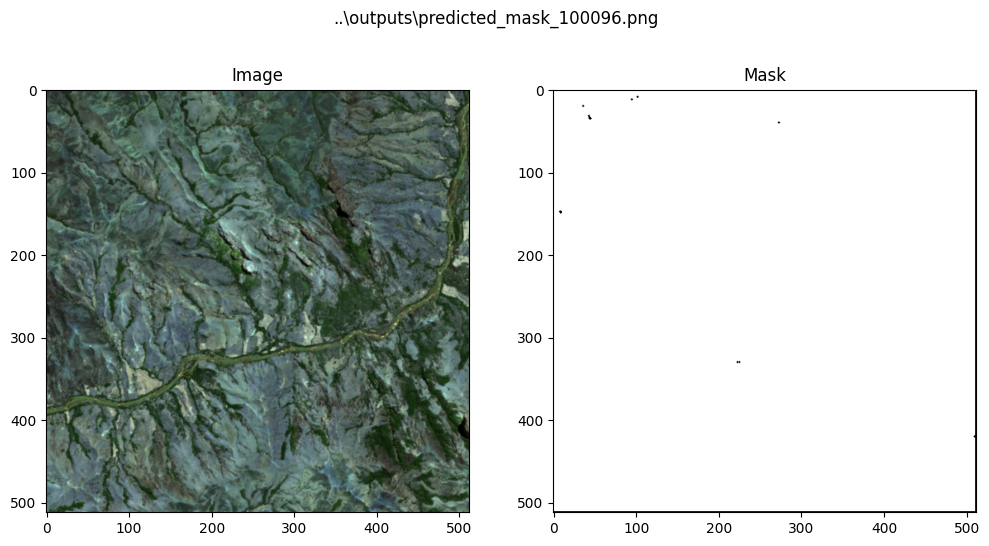

Saved prediction to ..\outputs\predicted_mask_100096.png


In [18]:
example_image = "test/data/100096.tif"
output_mask = config.OUTPUT_PATH / "predicted_mask_100096.png"
_ = predict_full_image(model, example_image, output_mask)

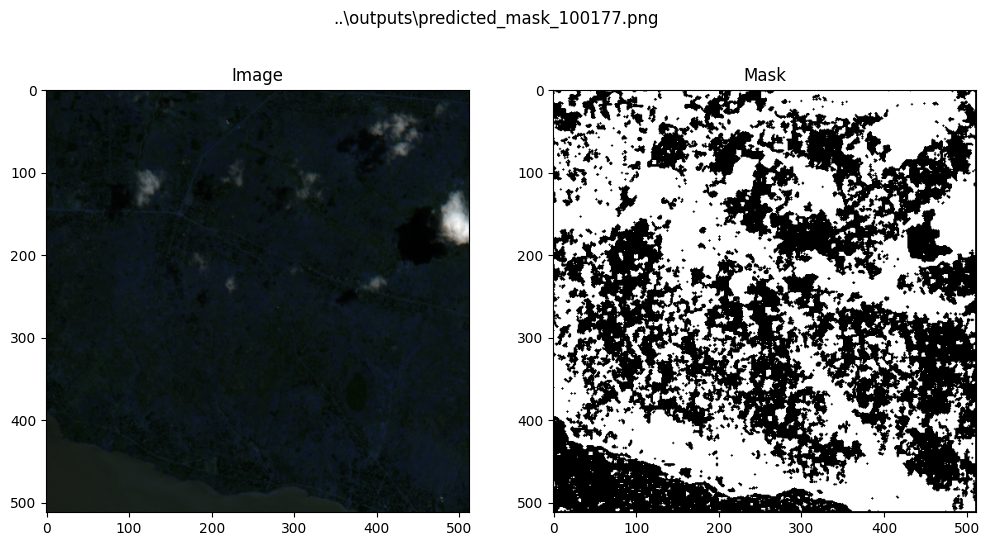

Saved prediction to ..\outputs\predicted_mask_100177.png


In [19]:
example_image = "test/data/100177.tif"
output_mask = config.OUTPUT_PATH / "predicted_mask_100177.png"
_ = predict_full_image(model, example_image, output_mask)

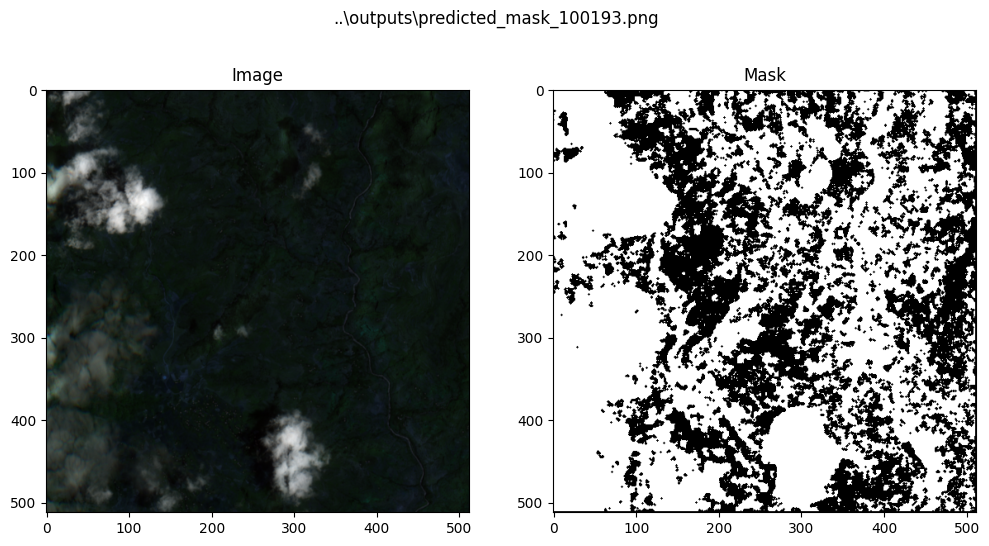

Saved prediction to ..\outputs\predicted_mask_100193.png


In [20]:
example_image = "test/data/100193.tif"
output_mask = config.OUTPUT_PATH / "predicted_mask_100193.png"
_ = predict_full_image(model, example_image, output_mask)

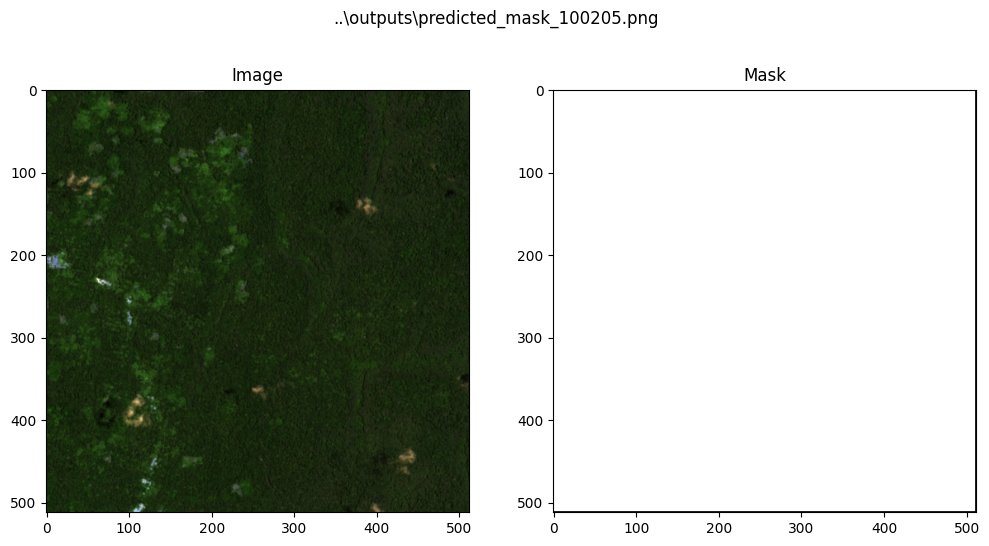

Saved prediction to ..\outputs\predicted_mask_100205.png


In [21]:
example_image = "test/data/100205.tif"
output_mask = config.OUTPUT_PATH / "predicted_mask_100205.png"
_ = predict_full_image(model, example_image, output_mask)

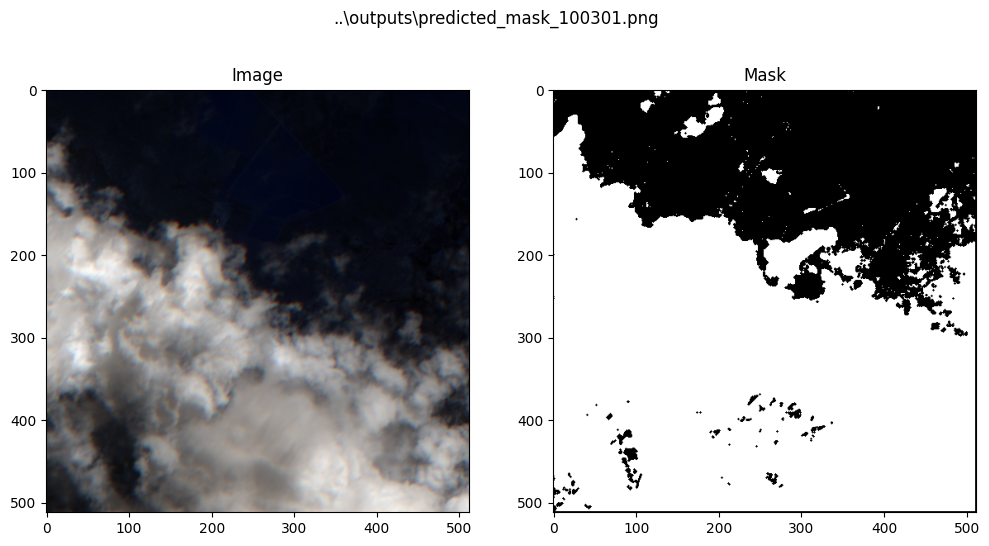

Saved prediction to ..\outputs\predicted_mask_100301.png


In [22]:
example_image = "test/data/100301.tif"
output_mask = config.OUTPUT_PATH / "predicted_mask_100301.png"
_ = predict_full_image(model, example_image, output_mask)